# 6. Elastic Net

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the $\textit{l1_ratio}$ parameter.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

The objective function to minimize is in this case

$$
\min_{w} \  {1\over{2n_{samples}}} ||Xw-y||_{2} ^2 + \alpha \rho ||w||_{1} + {\alpha(1 - \rho)\over{2}}||w||_{2}^2
$$

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import sklearn.linear_model as sklm
import scipy

kb = 1.38064e-23  # постоянная Больцмана
T = 273.15 + 22  # температура в K
theta = np.pi / 2  # угол рассеяния
n = 1.333  # показатель преломления
eta = 0.958e-3  # Н * с/м^2 - динамическая вязкость воды
l = 650e-9  # Длина волны лазера

coeff = (kb * T / (3 * np.pi * eta)) * (4 * np.pi * n / l) ** 2 * np.sin(theta / 2) ** 2

In [2]:
# диапазон размеров частиц, где ищем нужный размер 
d_min = 1e-9 # 1 нм
d_max = 1e-6 

# задаем сетку по Gamma
G_min = coeff/d_max
G_max = coeff/d_min
N = 256*8 # Число узлов в сетке по \Gamma

w = 2.0*np.arange(1,5001)
M = w.size # Число точек по частоте
p = (G_max/G_min)**(1/(N-1))
G = np.zeros(N)

# неравномерная сетка со сгущением к нулю (так как больщий вклад в интенсивность дают крупные частицы)
# хотя такая сетка - это не единственно возможный вариант
for j in range(N):
    G[j] = G_min * (p**j)

# вот равномерная сетка
#G = np.linspace(G_min, G_max, N)    

A = np.zeros((M,N))

# Матрица коэффициентов (составляется по базисным ф-ям)
for i in range(M):
    for j in range(N):
        A[i,j] = G[j] / ((2 * np.pi * w[i])**2 + G[j]**2)  

In [5]:
# Функция для построения для одного примера
import scipy.signal

def draw_given(w, d1, d2, i, y, y1 = [], y2 = []):
    fig = plt.figure()
    ax1 = plt.subplot(N_samples,2,2*i+1)
    
    if (len(y1) != 0): 
        plt.plot(w, y1, 'darkblue')
    if (len(y2) != 0): 
        plt.plot(w, y2, 'blue')
    
    plt.plot(w, y, 'red')
    #Вывод уже умножив на 1e+9
    ax1.set_title('Peaks given: [{0:.0f}, {1:.0f}]'.format(d1 * 1e+9, d2 * 1e+9)) # {0:2.0e}
    ax1.set_xlabel('Frequency')
    
def draw_found(w, i, y):
    clf = sklm.ElasticNetCV()
    clf.fit(A, y)
    a = clf.coef_
    
    ax2 = plt.subplot(N_samples,2,2*i+2)
    line, = plt.plot(1e+9 * coeff/G, a,'.-')
    ax2.set_xscale('log')
    plt.xlim(d_min*1e9, d_max*1e9)
    ax2.set_xlabel('Diameter, *10e-9')
    
    indexes, _ = scipy.signal.find_peaks(a, height=0.002, distance=10) #height нужно задавать правильный
    peaks = sorted(1e+9*coeff/G[indexes])
    if (len(peaks) == 2):
        ax2.set_title('Peaks found: [{0:.0f}, {1:.0f}]'.format(peaks[0], peaks[1])) # 'Peaks found: %s' % (1e+9*coeff/G[indexes])
    elif (len(peaks) == 3):
        ax2.set_title('Peaks found: [{0:.0f}, {1:.0f}, {2:.0f}]'.format(peaks[0], peaks[1], peaks[2]))
    else:
        ax2.set_title('Peak found: [{0:.0f}]'.format(peaks[0]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

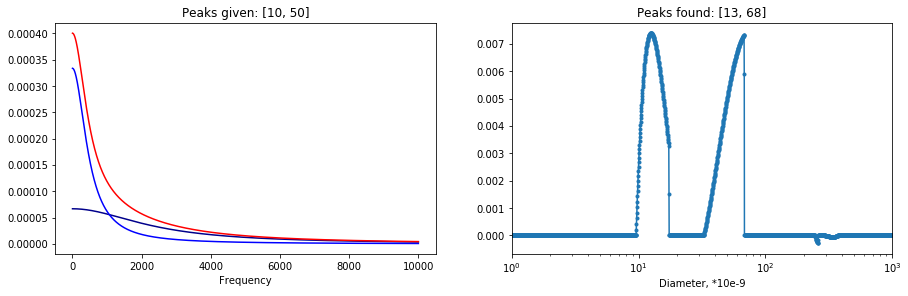

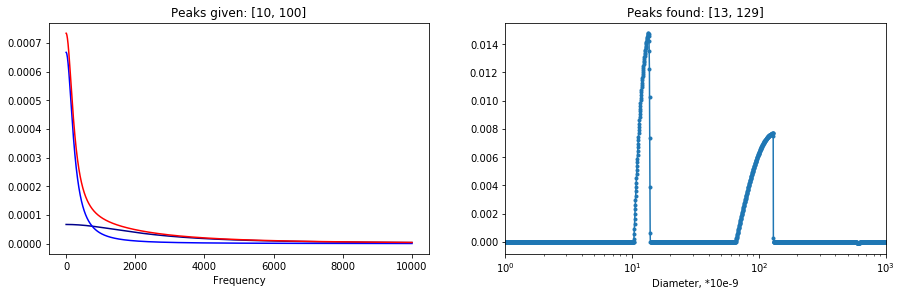

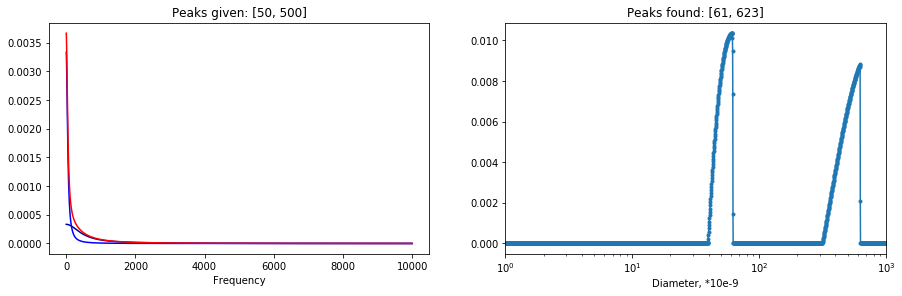

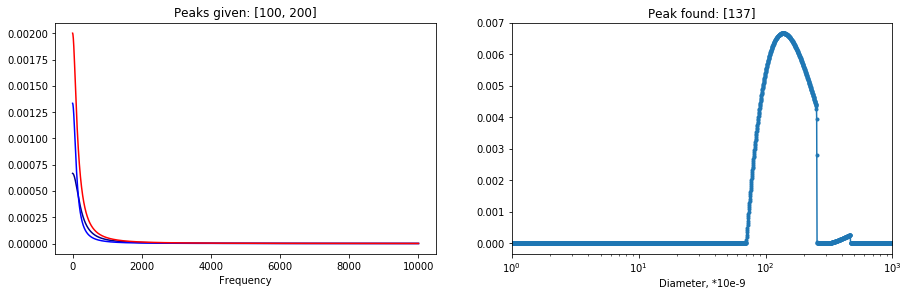

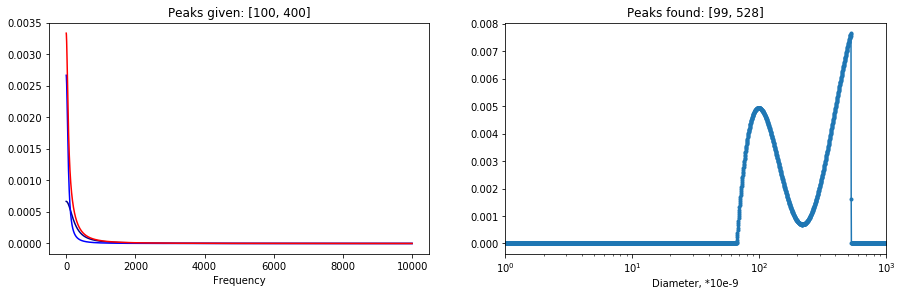

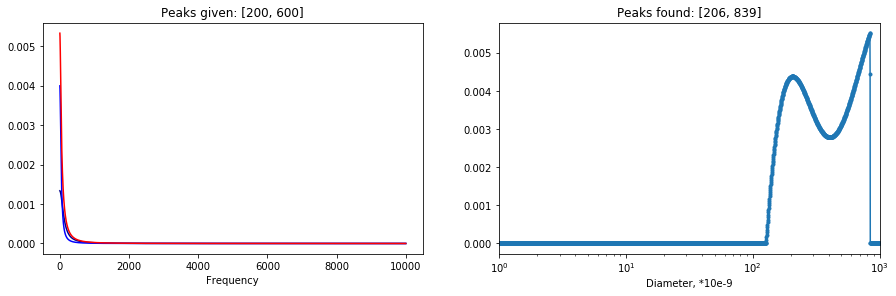

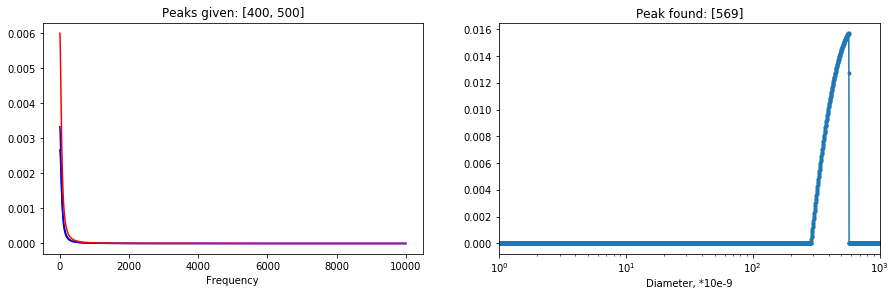

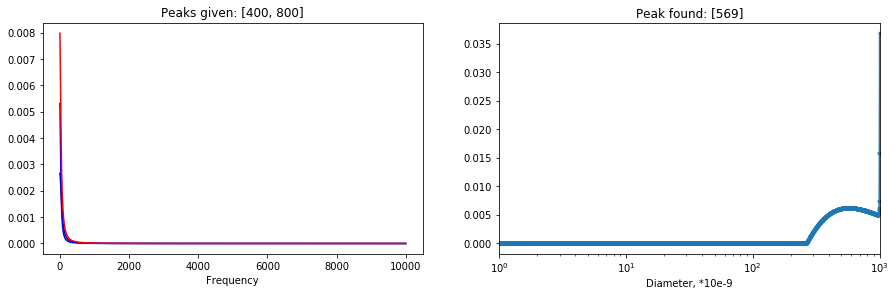

In [6]:
# Set samples
N_samples = 8

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15 #width
fig_size[1] = 5 * N_samples #height
plt.rcParams["figure.figsize"] = fig_size

d1_mass = [10, 10, 50, 100, 100, 200, 400, 400] 
d1_mass = [sample * 1e-9 for sample in d1_mass]

d2_mass = [50, 100, 500, 200, 400, 600, 500, 800]
d2_mass = [sample * 1e-9 for sample in d2_mass]

G1_mass = coeff / d1_mass
G2_mass = coeff / d2_mass

y_mass = np.zeros((N_samples, w.size))

for i in range(N_samples):
    y1 = G1_mass[i] / ((2 * np.pi * w)**2 + G1_mass[i]**2)
    y2 = G2_mass[i] / ((2 * np.pi * w)**2 + G2_mass[i]**2)
    y_mass[i,:] = y1 + y2

    draw_given(w, d1_mass[i], d2_mass[i], i, y_mass[i,:], y1, y2)
    draw_found(w, i, y_mass[i,:])